In [85]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

In [86]:
SEED = 42

In [87]:
spark = SparkSession.builder.appName("BigData projekt model 01").getOrCreate()

In [88]:
df = spark.read.csv("data/mountains_vs_beaches_preferences.csv",
                    sep=';',
                    inferSchema=True,
                    header=True)

In [89]:
print("Schema:")
df.printSchema()

Schema:
root
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Travel_Frequency: integer (nullable = true)
 |-- Preferred_Activities: string (nullable = true)
 |-- Vacation_Budget: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Proximity_to_Mountains: integer (nullable = true)
 |-- Proximity_to_Beaches: integer (nullable = true)
 |-- Favorite_Season: string (nullable = true)
 |-- Pets: integer (nullable = true)
 |-- Environmental_Concerns: integer (nullable = true)
 |-- Preference: integer (nullable = true)



In [90]:
from pyspark.sql import functions as F

# Policz ilość wystąpień dla każdej klasy w kolumnie "Preference"
class_counts = df.groupBy("Preference").count().collect()

# Znajdź minimalną liczbę próbek (najmniej liczebną klasę)
min_class_count = min([row["count"] for row in class_counts])

# Wyrównanie klas przez undersampling
balanced_df = None
for row in class_counts:
    class_label = row["Preference"]
    class_fraction = min_class_count / row["count"]
    sampled_class = df.filter(df.Preference == class_label).sample(withReplacement=False, fraction=class_fraction)
    
    if balanced_df is None:
        balanced_df = sampled_class
    else:
        balanced_df = balanced_df.union(sampled_class)

# Sprawdzenie wyrównanego zbioru
balanced_df.groupBy("Preference").count().show()


+----------+-----+
|Preference|count|
+----------+-----+
|         1|13148|
|         0|13123|
+----------+-----+



In [91]:
# Indeksowanie kolumn typu string (zakodowanie ich na wartości numeryczne)
string_cols = [field.name for field in balanced_df.schema.fields if str(field.dataType) == 'StringType()']
print(string_cols)
for col in string_cols:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_indexed")
    balanced_df = indexer.fit(balanced_df).transform(balanced_df)

['Gender', 'Education_Level', 'Preferred_Activities', 'Location', 'Favorite_Season']


In [92]:
# Sprawdzenie schematu danych
print("Schema:")
balanced_df.printSchema()

Schema:
root
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Travel_Frequency: integer (nullable = true)
 |-- Preferred_Activities: string (nullable = true)
 |-- Vacation_Budget: integer (nullable = true)
 |-- Location: string (nullable = true)
 |-- Proximity_to_Mountains: integer (nullable = true)
 |-- Proximity_to_Beaches: integer (nullable = true)
 |-- Favorite_Season: string (nullable = true)
 |-- Pets: integer (nullable = true)
 |-- Environmental_Concerns: integer (nullable = true)
 |-- Preference: integer (nullable = true)
 |-- Gender_indexed: double (nullable = false)
 |-- Education_Level_indexed: double (nullable = false)
 |-- Preferred_Activities_indexed: double (nullable = false)
 |-- Location_indexed: double (nullable = false)
 |-- Favorite_Season_indexed: double (nullable = false)



In [93]:
# Zbiór cech do modelu
feature_columns = [f"{col}_indexed" if col in string_cols else col for col in balanced_df.columns if col != "Preference"]
print(feature_columns)

['Age', 'Gender_indexed', 'Income', 'Education_Level_indexed', 'Travel_Frequency', 'Preferred_Activities_indexed', 'Vacation_Budget', 'Location_indexed', 'Proximity_to_Mountains', 'Proximity_to_Beaches', 'Favorite_Season_indexed', 'Pets', 'Environmental_Concerns', 'Gender_indexed', 'Education_Level_indexed', 'Preferred_Activities_indexed', 'Location_indexed', 'Favorite_Season_indexed']


In [94]:
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [95]:
# Normalizacja danych
# scaler = StandardScaler(inputCol="features_raw", outputCol="features", withStd=True, withMean=True)

In [96]:
# Random Forest Classifier
rf = RandomForestClassifier(labelCol="Preference", featuresCol="features", seed=SEED)

In [97]:
# Pipeline: indeksowanie + łączenie cech + model
pipeline = Pipeline(stages=[assembler, rf])

In [98]:
# Podział danych na zbiór treningowy i testowy
train, test = balanced_df.randomSplit([0.7, 0.3], SEED)

In [99]:
# Trening modelu
model = pipeline.fit(train)

In [100]:
# Ewaluacja modelu
predictions = model.transform(test)
predictions.select("features", "Preference", "prediction").show()

+--------------------+----------+----------+
|            features|Preference|prediction|
+--------------------+----------+----------+
|[18.0,1.0,20869.0...|         1|       1.0|
|[18.0,1.0,26859.0...|         1|       1.0|
|[18.0,1.0,27300.0...|         1|       1.0|
|[18.0,1.0,31168.0...|         1|       1.0|
|[18.0,1.0,35576.0...|         1|       1.0|
|[18.0,1.0,37814.0...|         1|       1.0|
|[18.0,1.0,38112.0...|         1|       1.0|
|[18.0,1.0,42012.0...|         1|       1.0|
|[18.0,1.0,42608.0...|         1|       1.0|
|[18.0,1.0,46376.0...|         1|       1.0|
|[18.0,1.0,47577.0...|         1|       1.0|
|[18.0,1.0,49800.0...|         1|       1.0|
|[18.0,1.0,50318.0...|         1|       1.0|
|[18.0,1.0,51790.0...|         1|       1.0|
|[18.0,1.0,52714.0...|         1|       1.0|
|[18.0,1.0,54204.0...|         1|       1.0|
|[18.0,1.0,54598.0...|         1|       1.0|
|[18.0,1.0,58402.0...|         1|       1.0|
|[18.0,1.0,63528.0...|         1|       1.0|
|[18.0,1.0

In [101]:
pred_result = predictions.groupBy('Preference', 'prediction').count()
pred_result.show()

+----------+----------+-----+
|Preference|prediction|count|
+----------+----------+-----+
|         1|       1.0| 3841|
|         0|       0.0| 3501|
|         0|       1.0|  402|
+----------+----------+-----+



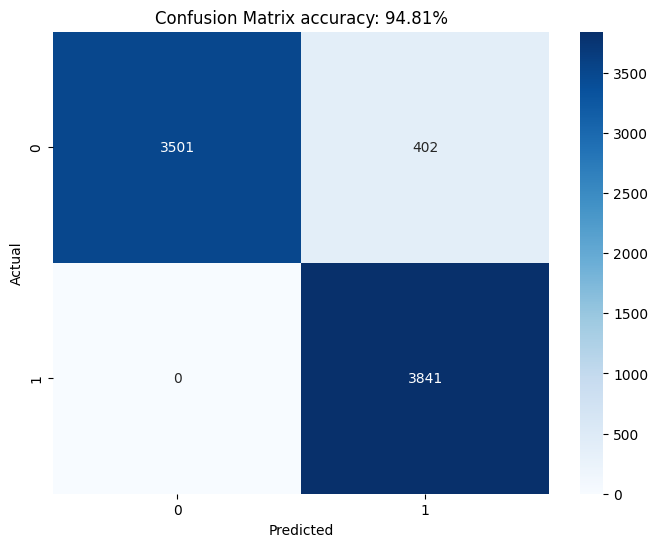

In [102]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = pred_result.toPandas()

matrix = np.zeros((2, 2))
for _, row in conf_matrix.iterrows():
    true_label = int(row["Preference"])
    pred_label = int(row["prediction"])
    count = int(row["count"])
    matrix[true_label][pred_label] = count

conf_matrix_df = pd.DataFrame(matrix)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df, annot=True, fmt="g", cmap="Blues")
plt.title(f"Confusion Matrix accuracy: {np.trace(matrix)/np.sum(matrix)*100:.2f}%")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [103]:
model.write().overwrite().save('/model/Balanced')

In [104]:
# Zatrzymanie SparkSession
# spark.stop()

['Gender', 'Education_Level', 'Preferred_Activities', 'Location', 'Favorite_Season']
+----------+----------+-----+
|Preference|prediction|count|
+----------+----------+-----+
|         1|       0.0| 6564|
|         0|       0.0|28618|
|         1|       1.0| 6584|
|         0|       1.0|10678|
+----------+----------+-----+



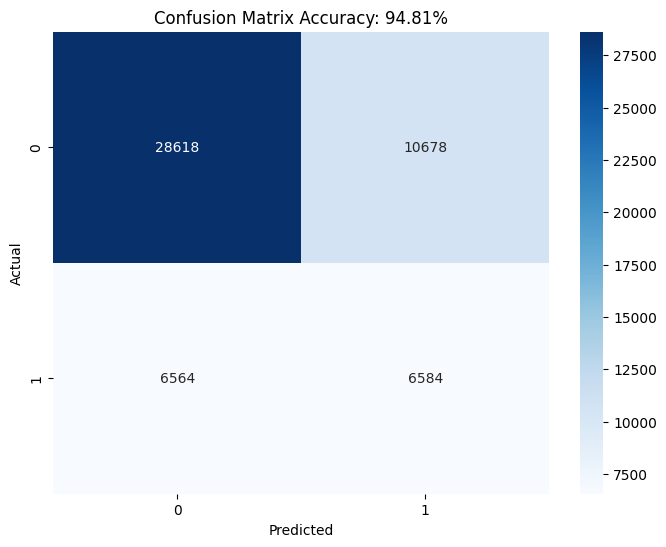

In [ ]:
# Indeksowanie kolumn typu string (zakodowanie ich na wartości numeryczne)
full_df = df
string_cols = [field.name for field in df.schema.fields if str(field.dataType) == 'StringType()']
print(string_cols)
for col in string_cols:
    indexer = StringIndexer(inputCol=col, outputCol=f"{col}_indexed")
    full_df = indexer.fit(full_df).transform(full_df)
    
# Ewaluacja modelu
full_data_predictions = model.transform(full_df)
# full_data_predictions.select("features", "Preference", "prediction").show()

full_data_pred_result = full_data_predictions.groupBy('Preference', 'prediction').count()

full_data_conf_matrix = full_data_pred_result.toPandas()

full_data_matrix = np.zeros((2, 2))
for _, row in full_data_conf_matrix.iterrows():
    true_label = int(row["Preference"])
    pred_label = int(row["prediction"])
    count = int(row["count"])
    full_data_matrix[true_label][pred_label] = count

full_data_conf_matrix_df = pd.DataFrame(full_data_matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(full_data_conf_matrix_df, annot=True, fmt="g", cmap="Blues")
plt.title(f"Confusion Matrix Accuracy: {np.trace(matrix)/np.sum(matrix)*100:.2f}%")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()